In [1]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
%matplotlib inline

import scipy

from itertools import combinations

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

import os
import sys

home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
home_dir = os.path.expanduser(home_dir)

tools_path = f'{home_dir}/code/processing/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools



# sns.set_style('dark')
# sns.set_style('ticks')
# plt.style.use('dark_background')

In [88]:
condition_properties = {'Evo1D_IRAs':{1:[0,1,4,7,10,13,16,19,22,24],
                                      2:[0,1,4,7,10,13,16,19,22,24]},
                        'Evo1D_TCG':{1:[0,1,4,8,10,13,16,19,22,24],
                                    2:[0,1,4,8,10,13,16,19,22,24]},
                        
                        'Evo2D_Ira1_Mis':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]
                                         },
                        'Evo2D_Ira1_Non':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]},
                        
                        'Evo3D_Ira1_Mis':{1:[0,1,4,7,10,14,17,21],
                                         2:[0,1,4,7,10,14,17,21],
                                         3:[0,1,4,7,10,14,17,21]},
                        'Evo3D_Ira1_Non':{1:[0,1,4,7,10,14,17,21],
                                         2:[0,1,4,7,10,14,17,21],
                                         3:[0,1,4,7,10,14,17,21]},
                        
                        'Evo3D_TCG':{1:[0,1,4,7,10,14,17,21],
                                         2:[0,1,4,7,10,14,17,21]},               
                       }


n_gens = 8
effective_n = 6 * 10**8 

In [123]:

mean_fitness_dict = {}

evolution_fitness_dict = {}

for condition,reps in condition_properties.items():
    this_data = p.read_csv(f'{condition}_counts_curated.csv')

    for rep,timepoints in reps.items():
        
        all_samples = []
        for time in timepoints:
            if time == 0:
                all_samples.append(f'{condition}_0_0_count')
            else:
                all_samples.append(f'{condition}_{rep}_{time}_count')
                
    
        this_data['barcode'] = this_data['fused_bc']

        this_fit_mut = p.read_csv(f'FitMut2_processing/out_fitmut1_thresholded/{condition}_{rep}_MutSeq_Result.csv')

        mean_fitness = this_fit_mut['Mean_Fitness'].values
        mean_fitness = mean_fitness[~np.isnan(mean_fitness)]
        
        mean_fitness_dict[f'{condition}_{rep}'] = mean_fitness

        kappas = this_fit_mut['Kappa_Value'].values
        kappas = kappas[~np.isnan(kappas)]


        mutant_cell_fraction = this_fit_mut['Mutant_Cell_Fraction'].values
        mutant_cell_fraction = mutant_cell_fraction[~np.isnan(mutant_cell_fraction)]

        this_fit_mut = this_fit_mut[['Fitness','Establishment_Time','Error_Fitness','Error_Establishment_Time','Likelihood_Log_Adaptive']]
#         this_fit_mut = this_fit_mut[['Fitness','Establishment_Time','Error_Fitness','Error_Establishment_Time','Probability_Adaptive']]
        this_fit_mut['barcode'] = this_data['barcode'] 
    
        for bc,fitness in zip(this_fit_mut['barcode'].values,this_fit_mut['Fitness'].values):
            if bc in evolution_fitness_dict:
                evolution_fitness_dict[bc][0].append(fitness)
                evolution_fitness_dict[bc][1].append(f'{condition}_R{rep}')

            else:
                evolution_fitness_dict[bc] = [[fitness],[f'{condition}_R{rep}']]



In [ ]:
home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
# home_dir = os.path.expanduser(home_dir)
rearray_map = p.read_csv(f'{home_dir}/data/BenomylTest/EvolvingFront_rearray_map_with_ploidy.csv')

remeasurement_data = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)

In [129]:
evolution_fitness_values = {}
evolution_fitness_conditions = {}

for bc,condition_sets in evolution_fitness_dict.items():
    fs = condition_sets[0]
    conditions = condition_sets[1]
    if bc in remeasurement_data['barcode'].values:
        evo_cond = remeasurement_data[remeasurement_data['barcode']==bc]['evolution_condition'].values[0]

        fs_filtered = []
        conditions_filtered = []
        for f,cond in zip(fs,conditions):
            if evo_cond in cond:
                fs_filtered.append(f)
                conditions_filtered.append(cond)

        if not np.any(fs_filtered): # if they are all 0
            evolution_fitness_values[bc] = np.nan
            evolution_fitness_conditions[bc] = np.nan
        else:
            entry = np.where(fs_filtered==np.max(fs_filtered))[0][0]
            evolution_fitness_values[bc] = fs_filtered[entry]
            evolution_fitness_conditions[bc] = conditions_filtered[entry]

In [130]:
home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
# home_dir = os.path.expanduser(home_dir)
rearray_map = p.read_csv(f'{home_dir}/data/BenomylTest/EvolvingFront_rearray_map_with_ploidy.csv')

remeasurement_data = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)

evolution_fitness = []
evolution_conditions = []

bcs_isolated_here = []
for bc,cloneID in zip(remeasurement_data['barcode'].values,remeasurement_data['cloneID_new'].values):
    
    if bc in evolution_fitness_values.keys():
        evolution_fitness.append( evolution_fitness_values[bc])
        evolution_conditions.append( evolution_fitness_conditions[bc])
    else:
        evolution_fitness.append(np.nan)
        evolution_conditions.append(np.nan)


remeasurement_data['evolution_fitness'] = evolution_fitness
remeasurement_data['isolated_evolution_condition'] = evolution_conditions
        
# overlapping_bcs = [bc for bc in this_data['barcode'].values if bc in isolated_here['barcode'].values]

In [139]:
remeasurement_data[~p.isnull(remeasurement_data['evolution_fitness'])]

,Fit1D-2%-R1_fitness,Fit1D-2%-R1_error,Fit1D-2%-R2_fitness,Fit1D-2%-R2_error,Fit1D-5%-R1_fitness,Fit1D-5%-R1_error,Fit1D-5%-R2_fitness,Fit1D-5%-R2_error,Fit2D-2%-R1_fitness,Fit2D-2%-R1_error,...,Fit1D_both2%5%_fitness_relative,Fit1D_both2%5%_fitness_ancestor,Fit2D_early_fitness_relative,Fit2D_early_fitness_ancestor,Fit3D_early_fitness_relative,Fit3D_early_fitness_ancestor,Fit5D_early_fitness_relative,Fit5D_early_fitness_ancestor,evolution_fitness,isolated_evolution_condition
0,0.770538,0.056064,0.798667,0.056490,0.793227,0.037792,0.777312,0.034586,1.152181,0.032200,...,0.141289,0.643256,1.490798,1.300109,1.823799,0.456141,1.452134,0.340931,0.062707,Evo2D_Ira1_Mis_R1
1,0.938763,0.035535,1.009834,0.036124,0.936852,0.024449,0.940881,0.024295,1.721427,0.024800,...,0.354352,0.595548,1.888121,1.497699,2.667791,0.846150,2.526322,0.547042,0.039214,Evo2D_Ira1_Mis_R1
10,0.754952,0.069179,0.733293,0.071339,0.648263,0.048402,0.673180,0.046180,0.982740,0.039512,...,0.043959,0.643256,1.661512,1.300109,2.082873,0.456141,2.091507,0.340931,0.082079,Evo2D_Ira1_Mis_R1
15,0.931648,0.042213,0.951872,0.042669,0.942970,0.030008,0.928367,0.027609,1.139749,0.030507,...,0.293877,0.643256,1.749402,1.300109,2.273101,0.456141,2.079417,0.340931,0.040194,Evo2D_Ira1_Mis_R1
17,0.985532,0.037513,0.960673,0.038194,0.801245,0.025972,0.885304,0.025508,1.564788,0.025966,...,0.261897,0.623017,1.874507,1.564134,2.473457,0.914799,2.760513,0.481995,0.058924,Evo2D_Ira1_Mis_R1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990,0.573561,0.097337,0.630648,0.109030,0.561142,0.071463,0.639930,0.059986,0.935238,0.050740,...,-0.038319,0.643256,0.953666,1.300109,1.395263,0.456141,0.710151,0.340931,0.225056,Evo2D_Ira1_Mis_R1
4128,1.150303,0.049900,1.142982,0.052846,1.032477,0.037458,1.116466,0.032821,1.104641,0.061329,...,0.457890,0.643256,1.055659,1.300109,1.315336,0.456141,0.623831,0.340931,0.070611,Evo2D_Ira1_Mis_R1
4489,0.598249,0.168415,0.734068,0.183168,0.614116,0.098734,0.590412,0.103155,0.858459,0.094311,...,-0.026127,0.643256,0.731220,1.300109,1.047130,0.456141,0.084155,0.340931,0.031595,Evo2D_Ira1_Mis_R1
4645,0.756447,0.144074,0.690834,0.151709,0.677987,0.088100,0.785262,0.078254,0.736555,0.209774,...,0.091683,0.643256,0.281199,1.300109,0.182995,0.456141,-0.008748,0.340931,0.035972,Evo1D_IRAs_R1


Text(0.5, 1.0, 'Evo2D_Ira1_Mis R1')

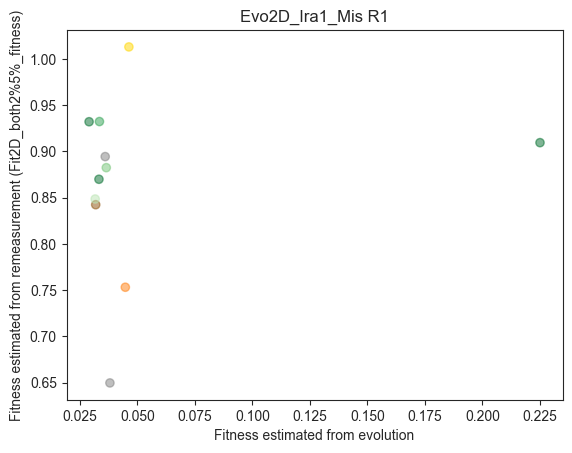

In [136]:

set_to_plot = remeasurement_data[(remeasurement_data['ancestor']=='IRA1_MIS') & 
                   (remeasurement_data['class_new']=='adaptive_haploid') & 
                                (remeasurement_data['evolution_condition']=='Evo2D')]

ancestor = 'IRA1_MIS'
fitness = 'Fit2D_both2%5%_fitness'
# fitness = 'Fit2D_early_fitness'

# barcodes_to_plot = set_to_plot['barcode'].values
# # genes = set_to_plot['gene'].values

# barcodes_to_plot = [bc for bc in barcodes_to_plot if bc in overlapping_bcs]

# # barcodes_to_plot = overlapping_bcs

# overlap_evo = this_fit_mut[this_fit_mut['barcode'].isin(barcodes_to_plot)]
# overlap_evo = overlap_evo.sort_values('barcode')

# overlap_fit = remeasurement_data[remeasurement_data['barcode'].isin(barcodes_to_plot)]
# overlap_fit = overlap_fit.sort_values('barcode')

# print(len(overlap_evo),len(overlap_fit))

# ancestor_fit = remeasurement_data[remeasurement_data['barcode']==tools.rebarcoding_source_mutants[ancestor]][fitness].values[0]

# # ancestor_fit = remeasurement_data[remeasurement_data[]


colors = [tools.find_mutation_color(gene) for gene in set_to_plot['gene'].values]

plt.scatter(set_to_plot['evolution_fitness'].values,
            set_to_plot[fitness].values,alpha=0.5,c=colors)

plt.xlabel('Fitness estimated from evolution')
plt.ylabel(f'Fitness estimated from remeasurement ({fitness})')
plt.title(f'{condition} R{rep}')

59 59


Text(0.5, 1.0, 'Evo2D_Ira1_Mis R1')

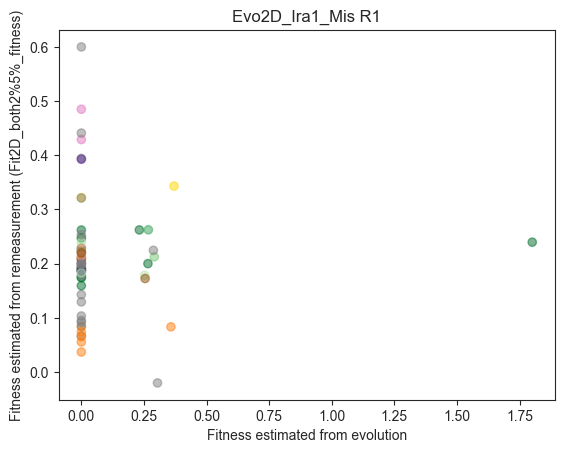

In [135]:

set_to_plot = remeasurement_data[(remeasurement_data['ancestor']=='IRA1_MIS') & 
                   (remeasurement_data['class_new']=='adaptive_haploid') & 
                                (remeasurement_data['evolution_condition']=='Evo2D')]
#                    (remeasurement_data['gene'].isin(['CIT1','KGD1','MDH1','RTG2','ARO80','GSH1']))
#                                 ]

ancestor = 'IRA1_MIS'
fitness = 'Fit2D_both2%5%_fitness'
# fitness = 'Fit2D_early_fitness'

barcodes_to_plot = set_to_plot['barcode'].values
# genes = set_to_plot['gene'].values

barcodes_to_plot = [bc for bc in barcodes_to_plot if bc in overlapping_bcs]

# barcodes_to_plot = overlapping_bcs

overlap_evo = this_fit_mut[this_fit_mut['barcode'].isin(barcodes_to_plot)]
overlap_evo = overlap_evo.sort_values('barcode')

overlap_fit = remeasurement_data[remeasurement_data['barcode'].isin(barcodes_to_plot)]
overlap_fit = overlap_fit.sort_values('barcode')

print(len(overlap_evo),len(overlap_fit))

ancestor_fit = remeasurement_data[remeasurement_data['barcode']==tools.rebarcoding_source_mutants[ancestor]][fitness].values[0]

# ancestor_fit = remeasurement_data[remeasurement_data[]


colors = [tools.find_mutation_color(gene) for gene in overlap_fit['gene'].values]

plt.scatter(8*overlap_evo['Fitness'].values,
            overlap_fit[fitness].values-ancestor_fit,alpha=0.5,c=colors)

plt.xlabel('Fitness estimated from evolution')
plt.ylabel(f'Fitness estimated from remeasurement ({fitness})')
plt.title(f'{condition} R{rep}')

In [23]:
import pingouin as pg

In [73]:
fitness = 'Fit2D_both2%5%_fitness'
fitness = 'Fit2D_early_fitness'


filtered_bcs = []
for bc in barcodes_to_plot:
    if (not this_fit_mut[this_fit_mut['barcode']==bc]['Fitness'].values[0] < 0.005): 
        if (not remeasurement_data[remeasurement_data['barcode']==bc][fitness].values[0] < 0.005):
            filtered_bcs.append(bc)
        

overlap_evo = this_fit_mut[this_fit_mut['barcode'].isin(filtered_bcs)]
overlap_evo = overlap_evo.sort_values('barcode')

overlap_fit = remeasurement_data[remeasurement_data['barcode'].isin(filtered_bcs)]
overlap_fit = overlap_fit.sort_values('barcode')

# overlap_fit = overlap_fit - ancestor_fit 



ancestor_fit = remeasurement_data[remeasurement_data['barcode']==tools.rebarcoding_source_mutants[ancestor]][fitness].values[0]



this_df = p.DataFrame(
                     {'barcode':filtered_bcs,
                      'evolution_fitness':overlap_evo['Fitness'].values,
                      'remeasured_fitness':overlap_fit[fitness].values-ancestor_fit,
                      'FerPerHour_relative':overlap_fit['FerPerHour_relative'].values,
                      'ResPerHour_relative':overlap_fit['ResPerHour_relative'].values})

In [81]:
pg.partial_corr(data=this_df, x='FerPerHour_relative', y='evolution_fitness', covar=['remeasured_fitness'])

,n,r,CI95%,p-val
pearson,56,0.124738,"[-0.15, 0.38]",0.364204


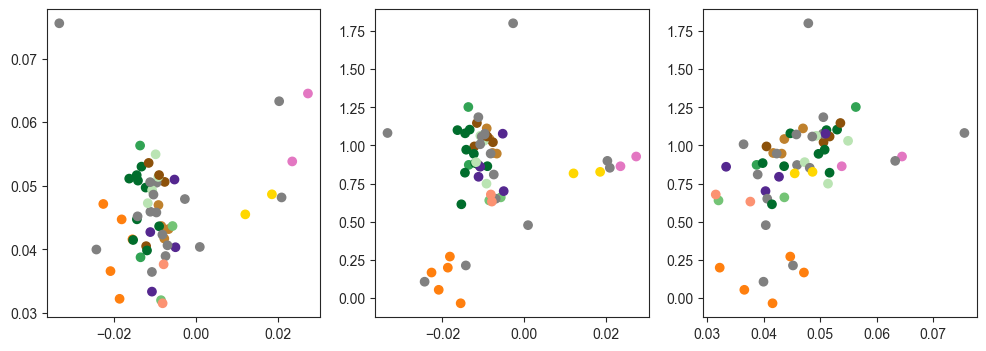

In [82]:
colors = [tools.find_mutation_color(gene) for gene in overlap_fit['gene'].values]

fig,axs = plt.subplots(ncols=3,figsize=(12,4))
axs[0].scatter(this_df['FerPerHour_relative'],this_df['evolution_fitness'],c=colors)

axs[1].scatter(this_df['FerPerHour_relative'],this_df['remeasured_fitness'],c=colors)

axs[2].scatter(this_df['evolution_fitness'],this_df['remeasured_fitness'],c=colors)



In [77]:
this_df[['evolution_fitness','remeasured_fitness','FerPerHour_relative','ResPerHour_relative']].pcorr()

,evolution_fitness,remeasured_fitness,FerPerHour_relative,ResPerHour_relative
evolution_fitness,1.000000,0.251285,-0.160341,-0.195283
remeasured_fitness,0.251285,1.000000,0.965244,0.989414
FerPerHour_relative,-0.160341,0.965244,1.000000,-0.970955
ResPerHour_relative,-0.195283,0.989414,-0.970955,1.000000


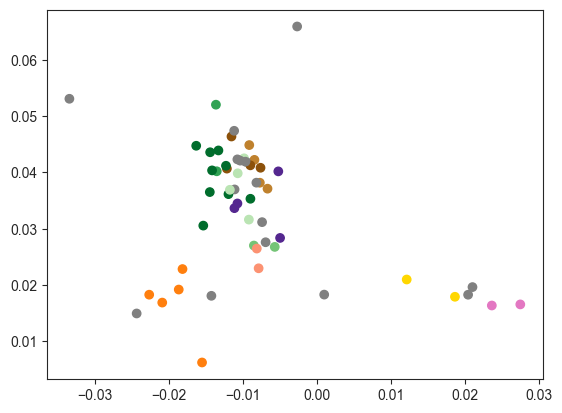

In [78]:
plt.scatter(this_df['FerPerHour_relative'],this_df['ResPerHour_relative'],c=colors)

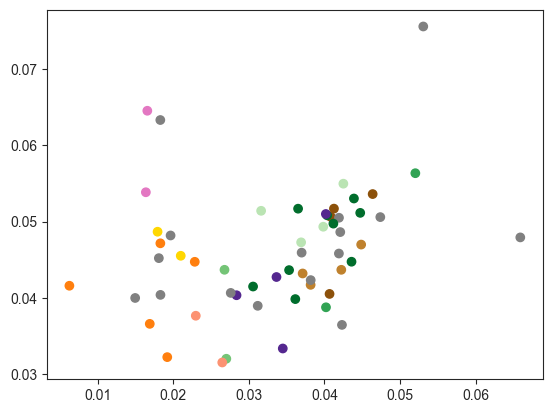

In [79]:
plt.scatter(this_df['ResPerHour_relative'],this_df['evolution_fitness'],c=colors)

In [141]:
set_to_plot[~p.isnull(set_to_plot['evolution_fitness'])]['barcode'].values

array(['TGATCAATCTACAAAAATATTTAATG_TATATAAGATGCAATCCCTTTATGCG',
       'TGATCAATCTACAAAAATATTTAATG_TGTGGAACGCAAAAGGAAATTCTTGC',
       'TGATCAATCTACAAAAATATTTAATG_GACAAAAACTACAATAGTCTTTTACC',
       'TGATCAATCTACAAAAATATTTAATG_GGGCCAAACTGTAACGTTCTTGGGGG',
       'TGATCAATCTACAAAAATATTTAATG_CTTCCAATATCGAACAGGTTTGCTAT',
       'CATTGAATCACAAAATAGGTTAGATG_TCGCTAACTAATAATGCTGTTTCAAT',
       'CATTGAATCACAAAATAGGTTAGATG_AGATTAACACAGAATCTCGTTAGACC',
       'CATTGAATCACAAAATAGGTTAGATG_ATGACAACAGTGAATTCTATTCCTGT',
       'TGATCAATCTACAAAAATATTTAATG_ACGACAATCTCGAATAGGTTTTTCTG',
       'TGATCAATCTACAAAAATATTTAATG_CTCTTAAACAGGAAATATATTATAGA',
       'TGATCAATCTACAAAAATATTTAATG_CAGATAATGATAAAATCCTTTACTAG'],
      dtype=object)

In [143]:
evolution_fitness_dict['TGATCAATCTACAAAAATATTTAATG_GGGCCAAACTGTAACGTTCTTGGGGG']

[[0.0334550451271581], ['Evo2D_Ira1_Mis_R1']]

In [144]:
evolution_fitness_dict

{'GAAATAAACCACAACGACATTCTAAT_AAACTAATTGGGAACACTTTTTAATG': [[0.0, 0.0],
  ['Evo1D_IRAs_R1', 'Evo1D_IRAs_R2']],
 'GAAATAAACCACAACGACATTCTAAT_GCATAAATATCGAAGTCTCTTATTAG': [[0.0, 0.0],
  ['Evo1D_IRAs_R1', 'Evo1D_IRAs_R2']],
 'GAAATAAACCACAACGACATTCTAAT_CCATTAATTTTCAATATTATTTTGGC': [[0.0, 0.0],
  ['Evo1D_IRAs_R1', 'Evo1D_IRAs_R2']],
 'CATAAAAAGACTAATCTTATTAATGC_GTGACAATATGAAACAGGATTTGACT': [[0.0, 0.0],
  ['Evo1D_IRAs_R1', 'Evo1D_IRAs_R2']],
 'CATAAAAAGACTAATCTTATTAATGC_GTGTGAACAACTAAACGTGTTGTTGA': [[0.0, 0.0],
  ['Evo1D_IRAs_R1', 'Evo1D_IRAs_R2']],
 'CATAAAAAGACTAATCTTATTAATGC_TCTCAAACTACTAACAATCTTAGTTT': [[0.0, 0.0],
  ['Evo1D_IRAs_R1', 'Evo1D_IRAs_R2']],
 'CATAAAAAGACTAATCTTATTAATGC_GAAAGAACAATAAACCCATTTGTAAT': [[0.0, 0.0],
  ['Evo1D_IRAs_R1', 'Evo1D_IRAs_R2']],
 'CATAAAAAGACTAATCTTATTAATGC_AATCAAAGCTTTAATTTTCTTTTGGT': [[0.0, 0.0],
  ['Evo1D_IRAs_R1', 'Evo1D_IRAs_R2']],
 'CATAAAAAGACTAATCTTATTAATGC_TGCGAAATAGAAAAGGTATTTCATGT': [[0.0, 0.0],
  ['Evo1D_IRAs_R1', 'Evo1D_IRAs_R2']],
 'CATAAAAA